#Data Preprocessing
###In this section, I will mostly focus on importing all the necessary packages to perform analysis, dealing with data to make it more suitable for the prediction model, and checking if there are missing values in the data. To begin with, I would like to briefly talk about the model I am going to use, I choose to use logistic regression as most of the variables are numerical and the target variable is binary. The training data has 165,034 rows of data and 14 features (including the target label), while the testing data has only 110,023 rows of data points and 13 features (without the target label). After dropping the unrelated features like the customer's surname and customer ID, there are two categorical variables in this dataset (Geography and Gender), and we will have to deal with them first. For the category variables in the dataset, I use one-hot encode to deal with them. This function creates new variables Geography_France, Geography_Germany, Geography_Spain, Gender_Male, and Gender_Female. I also listed out all the related variables we will use in this section and named it feature_cols.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve


### Load your datasets
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

### Preprocess data
# Handle missing values
train_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='ffill', inplace=True)

# Identify categorical features
categorical_features = ['Geography', 'Gender']

# Drop irrelevant columns
train_data = train_data.drop(['Surname', 'CustomerId'], axis=1)

# One-hot encode categorical features
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(train_data[categorical_features])
one_hot_encoded_test = one_hot_encoder.fit_transform(test_data[categorical_features])

# Convert the result into a DataFrame and concatenate with the original data
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
train_data = pd.concat([train_data.drop(categorical_features, axis=1), one_hot_encoded_df], axis=1)

one_hot_encoded_df = pd.DataFrame(one_hot_encoded_test, columns=one_hot_encoder.get_feature_names_out(categorical_features))
test_data = pd.concat([test_data.drop(categorical_features, axis=1), one_hot_encoded_df], axis=1)

#List out all the related variables for prediction
feature_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#Feature Selection- Recursive Feature Elimination (RFE)
###In this section, I am going to implement feature selection on the dataset as the initial run of the model(with all features included) outputs low accuracy and ROC-AUC score. Recursive Feature Elimination is a technique used in machine learning to identify and remove features from a dataset that are considered less important for building a model. First, it begins by considering all the features available in the dataset. Then an importance score is assigned to each feature based on a chosen machine learning model.expand_more This score reflects how much a particular feature contributes to the model's performance. We then can eliminate the features with the lowest importance scores from the dataset. As you can see below, the output of RFE indicates that the features 'CreditScore', 'Balance', and 'EstimateSalary' are not as important as others, so I remove them from feature_cols. By eliminating less important features, RFE helps achieve a few goals, and it helps us focus on the most relevant features can lead to a more accurate and efficient model. Moreover, it reduces the complexity of the model and helps prevent the model from overfitting to the training data, improving its generalizability to unseen data.

In [2]:
X_train = train_data[feature_cols]
y_train = train_data['Exited']
model = LogisticRegression(random_state=16)
rfe = RFE(estimator=model, n_features_to_select=10)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Num Features: 10
Selected Features: [False  True  True False  True  True  True False  True  True  True  True
  True]
Feature Ranking: [2 1 1 3 1 1 1 4 1 1 1 1 1]


#Prediction Model - Logistic Regression
###This is a classic and interpretable model well-suited for binary classification problems like churn prediction. It estimates the probability of an event (customer churn) happening based on a set of independent variables (customer data points). Logistic regression provides a clear picture of which factors are most influential in customer churn. Since the test data isn't labeled, we can't directly calculate accuracy in the traditional sense. I decided to divide the training data into two sets: a training subset and a validation subset. We train our model on the training subset and use the validation subset to evaluate its performance. This gives us an idea of how well the model generalizes to unseen data. That way, we can compare the predicted exit probabilities on the validation set with the actual exit labels to estimate accuracy metrics like AUC-ROC (Area Under the Receiver Operating Characteristic Curve). However, after I thoroughly tested my original model, I realized there were data imbalance issues using the normal logistic model (as I received a fairly low recall rate for the class of 1).

### To achieve a better recall rate for the minority, I used Cost-Sensitive logistic regression by adding this line of code "class_weight='balanced" in the logistic model. This approach assigns weights to different classes during training. The model emphasizes correctly classifying the minority class(which is 1 in our case) by penalizing errors made on those data points more heavily. Moreover, to further address the data imbalance issue, I manually adjust the threshold for the prediction based on the Precision-Recall Curve I have generated below. I decided to set the threshold at 0.7 as it meets a good balance between accuracy, precision, and recall for both majority and minority classes.

###As you can see below, we receive fairly good outputs when predicting the majority class. And the score from the minority class is fair and the recall is better than the original output. I have included the codes and output for my original model in the Appendix section below, feel free to have a look. Neverthless, there's a slight decrease in overall accuracy (0.8317 vs 0.8274). This is a common trade-off when adjusting the threshold to improve performance on the minority class. Precision decreased from 0.68 to 0.60. This means the model is including some false positives (predicting class 1 when it's actually class 0) more often. Recall increased significantly from 0.38 to 0.51. This is a significant improvement! It indicates the model is now capturing more true positive cases from the minority class, which was likely the goal of the threshold adjustment.

In [8]:
#Remove 'CreditScore', 'Balance', and 'EstimatedSalary' from feature_cols
feature_cols = ['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
logreg = LogisticRegression(random_state=16, class_weight='balanced')

X_train = train_data[feature_cols]
y_train = train_data['Exited']


# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test = test_data[feature_cols]

# Fit the model with training data
logreg.fit(X_train, y_train)


# Evaluate the model using the validation set
y_val_prob = logreg.predict_proba(X_val)[:, 1]

# Adjust threshold manually
threshold = 0.7  # Adjust this value based on precision-recall curve analysis
y_val_pred = (y_val_prob >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("AUC-ROC Score:", roc_auc_score(y_val, y_val_prob))

# Make predictions on the test data
y_pred_prob = logreg.predict_proba(X_test)[:, 1]  # Predicted probabilities
y_pred = (y_pred_prob >= threshold).astype(int)

# Output predictions with probabilities, ID and surname
predictions = pd.DataFrame({
    'id': test_data['CustomerId'],
    'surname': test_data['Surname'],
    'predicted_exited': y_pred,
    'exit_probability': y_pred_prob
})

print(predictions)

predictions.to_csv('predicted_output.csv', index=False)

count_1 = sum(y_pred)
count_0 = len(y_pred) - count_1

print(f"Number of customers predicted to exit (1): {count_1}")
print(f"Number of customers predicted not to exit (0): {count_0}")

Accuracy: 0.8260974944708698
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     26052
           1       0.60      0.51      0.55      6955

    accuracy                           0.83     33007
   macro avg       0.74      0.71      0.72     33007
weighted avg       0.82      0.83      0.82     33007

AUC-ROC Score: 0.8188697399207006
              id    surname  predicted_exited  exit_probability
0       15773898   Lucchese                 0          0.077018
1       15782418       Nott                 1          0.816474
2       15807120         K?                 0          0.378186
3       15808905  O'Donnell                 0          0.438405
4       15607314    Higgins                 1          0.717789
...          ...        ...               ...               ...
110018  15662091      P'eng                 0          0.111063
110019  15774133        Cox                 0          0.329756
110020  15

#Precision-Recall Curve (PRC)
###This curve shows the trade-off between precision and recall for different probability thresholds. As we lower the threshold, we will capture more positive predictions (increase recall), but also include more false positives (decrease precision). I use this as the reference to manually adjust the threshold for the model.

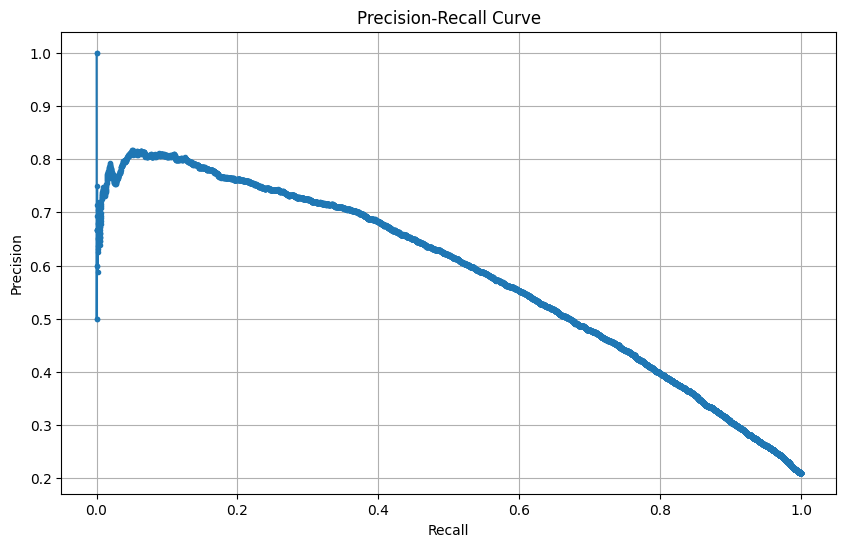

In [31]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

#Visulization of the Data and Output

##Heatmap for the Variables
###The following heatmap shows the correlation between each features(variables). This heat map can help us identify the features highly correlated with the target and the detect multicollinearity. If the correlation is high enough between two variables (over +-0.7), they might casue multicollinearity and affect the model performance, and we may consider removing one of the correlated features.

                         id  CreditScore       Age    Tenure   Balance  \
id                 1.000000    -0.001201  0.004039 -0.002560  0.000606   
CreditScore       -0.001201     1.000000 -0.008918  0.000942  0.006973   
Age                0.004039    -0.008918  1.000000 -0.010830  0.064318   
Tenure            -0.002560     0.000942 -0.010830  1.000000 -0.009481   
Balance            0.000606     0.006973  0.064318 -0.009481  1.000000   
NumOfProducts     -0.000094     0.011361 -0.102195  0.007335 -0.361033   
HasCrCard         -0.004706    -0.002828 -0.012111  0.005327 -0.018584   
IsActiveMember     0.000418     0.014790  0.003320 -0.005532 -0.015073   
EstimatedSalary   -0.001552    -0.001820 -0.005399  0.000971  0.008586   
Exited             0.002512    -0.027383  0.340768 -0.019565  0.129743   
Geography_France  -0.004797    -0.005669 -0.066439  0.002960 -0.332811   
Geography_Germany  0.000527     0.002996  0.093138 -0.007751  0.539208   
Geography_Spain    0.005218     0.0038

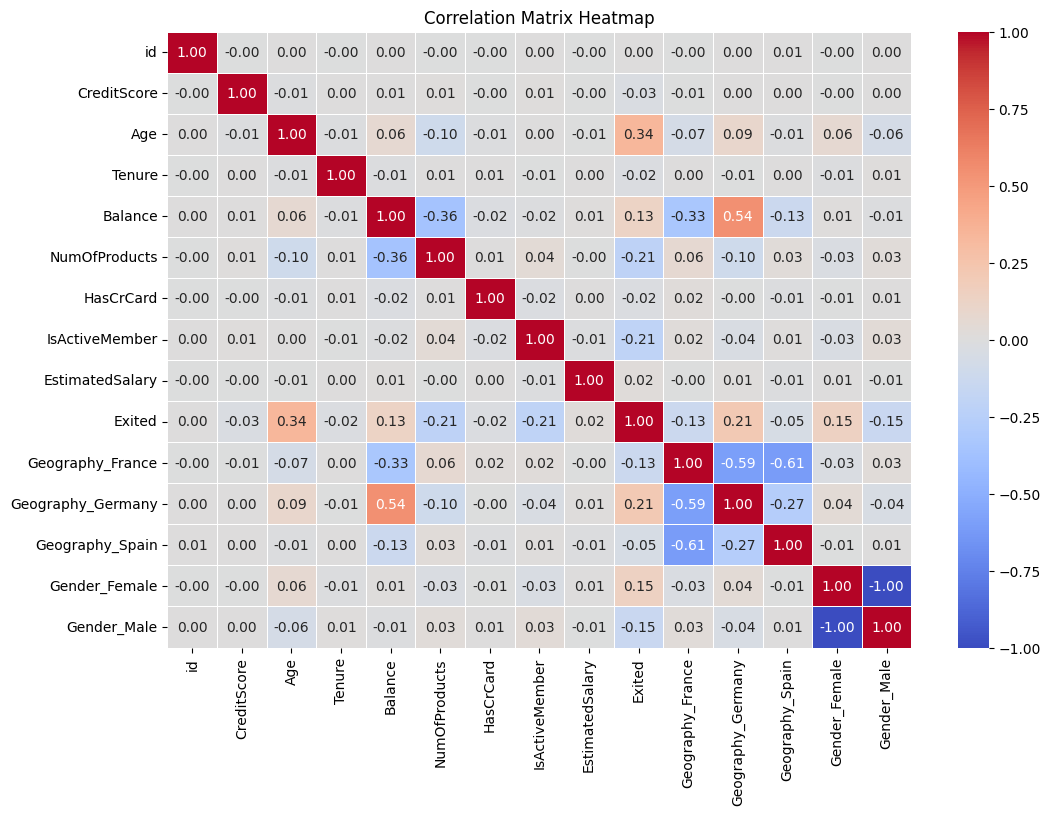

Exited               1.000000
Age                  0.340768
Geography_Germany    0.211054
Gender_Female        0.146442
Balance              0.129743
EstimatedSalary      0.018827
id                   0.002512
Tenure              -0.019565
HasCrCard           -0.022141
CreditScore         -0.027383
Geography_Spain     -0.051175
Geography_France    -0.130797
Gender_Male         -0.146442
IsActiveMember      -0.210237
NumOfProducts       -0.214554
Name: Exited, dtype: float64


In [4]:
# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Print the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Filter to show correlations with the target variable only
target_corr = corr_matrix['Exited'].sort_values(ascending=False)
print(target_corr)

#Bar Chart and Histogram on Predicted the Test Dataset
###The bar chart below gives us an insight into the total amount of customers that are predicted to exit and not exit. The model uses the test dataset and predicts 90,571 customers that will not exit and 19,452 that will exit. On the other hand, the histogram below shows the distribution of the predicted probability of the customers from the test dataset.

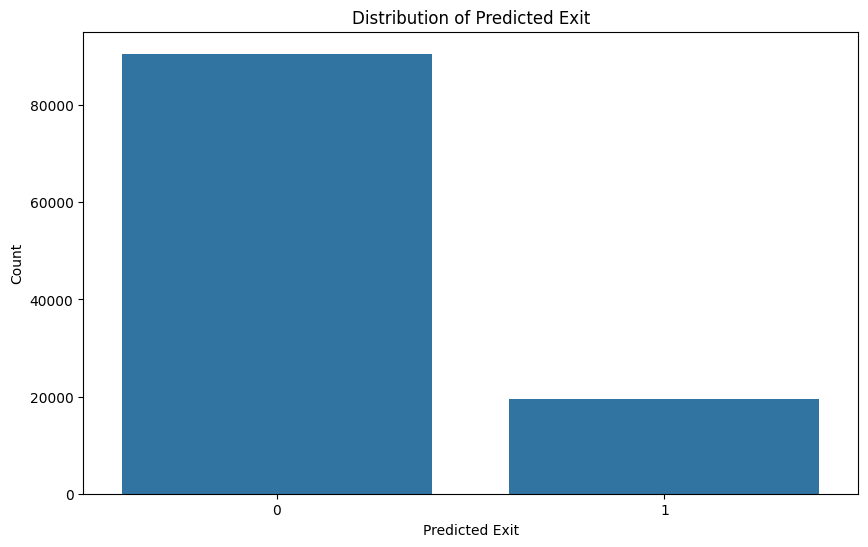

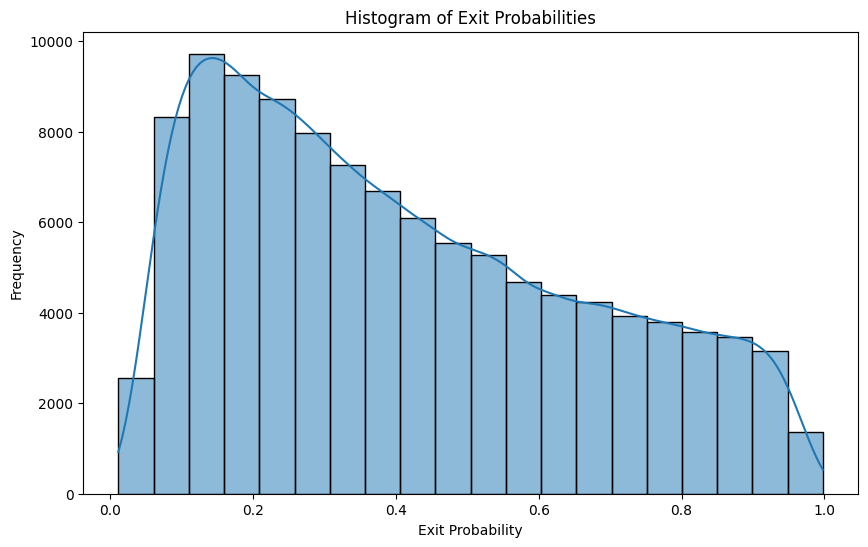

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the distribution of predictions
plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_exited', data=predictions)
plt.title('Distribution of Predicted Exit')
plt.xlabel('Predicted Exit')
plt.ylabel('Count')
plt.show()

# Plotting the probabilities of exit
plt.figure(figsize=(10, 6))
sns.histplot(predictions['exit_probability'], bins=20, kde=True)
plt.title('Histogram of Exit Probabilities')
plt.xlabel('Exit Probability')
plt.ylabel('Frequency')
plt.show()


#ROC-AUC curve (Receiver Operating Characteristic Area Under the Curve)
###This is a valuable tool in machine learning for evaluating the performance of classification models.The core idea is that the AUC tells us how well our model separates positive and negative classes. A higher AUC indicates a better ability to differentiate between the two.The AUC value summarizes the ROC curve's performance into a single metric, ranging from 0 to 1. An AUC of 1 represents a perfect model, while 0.5 indicates a random guess.In our case, I use validation set that is seperated from the training set to assess how well the model is going to be to predict the datapoints from testing set(as the testing set is not labeled), the AUC-ROC Score is about 0.82, which indicates the model is considered good in separates positive and negative classes.


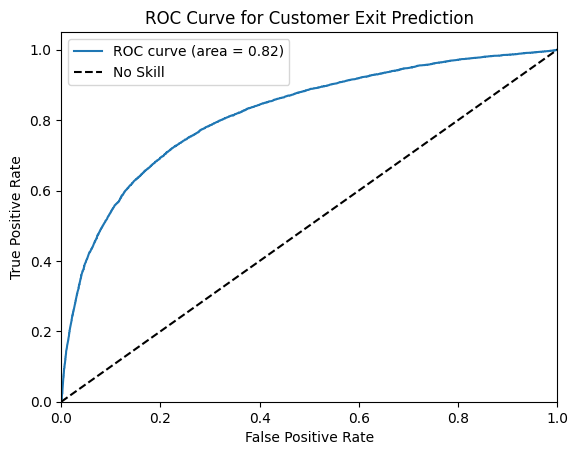

In [5]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Customer Exit Prediction')
plt.legend()
plt.show()

#Appendix
##Original Model (Logistic Regression)

In [6]:
#Remove 'CreditScore', 'Balance', and 'EstimatedSalary' from feature_cols
feature_cols = ['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
logreg = LogisticRegression(random_state=16)

X_train = train_data[feature_cols]
y_train = train_data['Exited']


# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = test_data[feature_cols]

# fit the model with data
logreg.fit(X_train, y_train)

# Evaluate the model using the validation set
y_val_pred = logreg.predict(X_val)
y_val_prob = logreg.predict_proba(X_val)[:, 1]


print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("AUC-ROC Score:", roc_auc_score(y_val, y_val_prob))

# Make predictions on the test data
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]  # Predicted probabilities

# Output predictions with probabilities, ID and surname
predictions = pd.DataFrame({
    'id': test_data['CustomerId'],
    'surname': test_data['Surname'],
    'predicted_exited': y_pred,
    'exit_probability': y_pred_prob
})

print(predictions)

count_1 = sum(y_pred)
count_0 = len(y_pred) - count_1

print(f"Number of customers predicted to exit (1): {count_1}")
print(f"Number of customers predicted not to exit (0): {count_0}")


Accuracy: 0.8333989759747932
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90     26052
           1       0.69      0.38      0.49      6955

    accuracy                           0.83     33007
   macro avg       0.77      0.67      0.70     33007
weighted avg       0.82      0.83      0.81     33007

AUC-ROC Score: 0.8179124855967432
              id    surname  predicted_exited  exit_probability
0       15773898   Lucchese                 0          0.020368
1       15782418       Nott                 1          0.569766
2       15807120         K?                 0          0.143247
3       15808905  O'Donnell                 0          0.194486
4       15607314    Higgins                 0          0.431361
...          ...        ...               ...               ...
110018  15662091      P'eng                 0          0.034242
110019  15774133        Cox                 0          0.121276
110020  15

##Weighted Logistic Regression Model without manually adjust the threshold.

In [7]:
#Remove 'CreditScore', 'Balance', and 'EstimatedSalary' from feature_cols
feature_cols = ['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
logreg = LogisticRegression(random_state=16, class_weight='balanced')

X_train = train_data[feature_cols]
y_train = train_data['Exited']


# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test = test_data[feature_cols]

# fit the model with data
logreg.fit(X_train, y_train)

# Evaluate the model using the validation set
y_val_pred = logreg.predict(X_val)
y_val_prob = logreg.predict_proba(X_val)[:, 1]


print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("AUC-ROC Score:", roc_auc_score(y_val, y_val_prob))

# Make predictions on the test data
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]  # Predicted probabilities

# Output predictions with probabilities, ID and surname
predictions = pd.DataFrame({
    'id': test_data['CustomerId'],
    'surname': test_data['Surname'],
    'predicted_exited': y_pred,
    'exit_probability': y_pred_prob
})

print(predictions)

count_1 = sum(y_pred)
count_0 = len(y_pred) - count_1

print(f"Number of customers predicted to exit (1): {count_1}")
print(f"Number of customers predicted not to exit (0): {count_0}")

Accuracy: 0.7518102220741055
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83     26052
           1       0.45      0.74      0.56      6955

    accuracy                           0.75     33007
   macro avg       0.68      0.75      0.69     33007
weighted avg       0.82      0.75      0.77     33007

AUC-ROC Score: 0.8188697399207006
              id    surname  predicted_exited  exit_probability
0       15773898   Lucchese                 0          0.077018
1       15782418       Nott                 1          0.816474
2       15807120         K?                 0          0.378186
3       15808905  O'Donnell                 0          0.438405
4       15607314    Higgins                 1          0.717789
...          ...        ...               ...               ...
110018  15662091      P'eng                 0          0.111063
110019  15774133        Cox                 0          0.329756
110020  15